In [4]:
import os
import re
import sys
import argparse
import subprocess
import time
import pandas as pd
import numpy as np
from itertools import groupby
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import warnings
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
import pickle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from pylab import *
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.output_wrapper, .output {    height:auto !important;max-height:1000px;  /* your desired max-height here */}.output_scroll {    box-shadow:none !important;    webkit-box-shadow:none !important;}</style>"))

import os
os.chdir("/home/pavel-kravchenko/")

In [5]:
#setting TFs
TF_list = ["ANDR_HUMAN", "ANDR_MOUSE"]
key = 1

#all cook things

def init_paths(TF):
    root = os.getcwd()
    inputdir = os.path.abspath('train/')
    outputdir = os.path.abspath('result/' + TF)
    basicdir = os.path.abspath('result/')
    pwmdir = os.path.abspath('pwm/mono/' + TF)
    
    if not os.path.exists(basicdir):
        os.makedirs(basicdir)
    if not os.path.exists(outputdir):
        os.makedirs(outputdir)
    
    files_train = [f for f in os.listdir(inputdir) if os.path.splitdrive(f)[1].split(".")[0] == TF]
    files_test = [f for f in os.listdir(inputdir) if os.path.splitdrive(f)[1].split(".")[0] != TF]
    files_mfa = [f for f in os.listdir(inputdir) if os.path.splitext(f)[1] == '.mfa']
    files_pwm = [f for f in os.listdir(pwmdir) if os.path.splitext(f)[1] == '.pwm']
    
    #print(files_train)
    #print(files_test)
    #print(files_pwm)
    return root, inputdir, outputdir, pwmdir, files_train, files_test, files_mfa, files_pwm, basicdir

#for i in TF_list: 
    #root, inputdir, outputdir, pwmdir, files_train, files_test, files_mfa, files_pwm, basicdir = init_paths(i)
    
root, inputdir, outputdir, pwmdir, files_train, files_test, files_mfa, files_pwm, basicdir = init_paths(TF_list[key])

!pwd

FileNotFoundError: [Errno 2] No such file or directory: '/home/pavel-kravchenko/pwm/mono/ANDR_MOUSE'

In [8]:
#indexing mfa files

def fasta_iter(f):
    faiter = (x[1] for x in groupby(f, lambda line: line[0] == ">"))

    for header in faiter:
        headerStr = header.__next__()[1:].strip()
        seq = "".join(s.strip() for s in faiter.__next__())
        yield (headerStr, seq)


#writing all_mfa_indexing_file.fasta

def all_mfa_indexing_file_writer(inputdir, basicdir, files_mfa):
    outfile = open(basicdir + "/all_mfa_indexing_file.fasta", "w")        
    index_global = 0
    for i in files_mfa:
        headerStr_base = "_".join(i.split(".")[:-1])
        #print(headerStr_base)
        with open(inputdir + "/" + i, "r") as f:
            fiter = fasta_iter(f)
            index_local = 0
            for seq_rec in fiter:
                headerStr_new = headerStr_base + "_globalInd_" + str(index_global) + "_localInd_" + str(index_local)
                headerStr, seq = seq_rec
                outfile.write(">" + headerStr_new + "\n" + seq + "\n")
                index_local += 1
        index_global += 1
        #break
    outfile.close()
    
all_mfa_indexing_file_writer(inputdir, basicdir, files_mfa)


#cleaning from ""
os.chdir(basicdir)
!awk 'NF' `pwd`/all_mfa_indexing_file.fasta > `pwd`/all_mfa_indexing_file_no_NF.fasta
os.chdir(outputdir)

In [71]:
good_pwm = open(root + "/good_files.txt", "r") 
good_list = [x for x in good_pwm.read().strip().split()]
#print(good_list)

In [131]:
f = open(basicdir + "/all_mfa_indexing_file_no_NF.fasta", "r") 
all_mfa = fasta_iter(f)
headerStr_names = []
for seq_rec in all_mfa:
    headerStr, seq = seq_rec
    headerStr_names.append(headerStr)
    #print(headerStr)  
dic = pd.DataFrame({'Names': headerStr_names})

pd.DataFrame.to_csv(dic, outputdir + "/out.tab",  sep='\t', header=False)

In [191]:
safe_list = list()
print(len(safe_list))
N_features = 20

0


In [168]:
import subprocess, threading


class Command(object):
    def __init__(self, cmd):
        self.cmd = cmd
        self.process = None

    def run(self, timeout):
        def target():
            print('Thread started')
            self.process = subprocess.Popen(self.cmd, shell=True)
            self.process.communicate()
            print('Thread finished')

        thread = threading.Thread(target=target)
        thread.start()

        thread.join(timeout)
        if thread.is_alive():
            print('Terminating process')
            self.process.terminate()
            thread.join()
        print(self.process.returncode)


def sarus(outputdir, files_pwm, pwmdir, good_lines, safe_list):
    o = 0
    print(len(files_pwm))
    for i in files_pwm:
        #print(".".join(i.split("~")[2].split(".")[:-2]))
        if ".".join(i.split("~")[2].split(".")[:-2]) != "#": #"ANDR_MOUSE.PEAKS036543.pics": # "ANDR_HUMAN.PEAKS035082.sissrs":
            if ".".join(files_pwm[0].split("~")[2].split(".")[:-1]) in good_list and i not in safe_list:
                line = 'java -Xmx2G -cp {sarsus_home} ru.autosome.SARUS {mfa_file} {matrix} --skipn --show-non-matching --output-scoring-mode score besthit | grep -v \> > {out_file}'.format(sarsus_home = root + "/sarus/releases/sarus-2.0.1.jar",
                mfa_file = '/'.join([basicdir, "all_mfa_indexing_file_no_NF.fasta"]),
                matrix = '/'.join([pwmdir, i]),
                out_file = '/'.join([outputdir, "_".join(i.split(".")[:-1]) + "_feature_compare_table.tab"]))
                print(line)
                
                p = subprocess.Popen(line, shell=True)
                #p.wait()
                #command = Command(line)
                #command.run(timeout=3)
                
                o += 1
                safe_list.append(i)
                if o == N_features+5:
                    break
            else:
                print("Doesn't in good_list or already done! ----- rejected")
            
sarus(outputdir, files_pwm, pwmdir, good_list, safe_list)
print(len(safe_list))

115
java -Xmx2G -cp /home/pavel-kravchenko/sarus/releases/sarus-2.0.1.jar ru.autosome.SARUS /home/pavel-kravchenko/result/all_mfa_indexing_file_no_NF.fasta /home/pavel-kravchenko/pwm/mono/ANDR_MOUSE/ANDR_MOUSE~CM~ANDR_MOUSE.PEAKS035586.gem.M.pwm --skipn --show-non-matching --output-scoring-mode score besthit | grep -v \> > /home/pavel-kravchenko/result/ANDR_MOUSE/ANDR_MOUSE~CM~ANDR_MOUSE_PEAKS035586_gem_M_feature_compare_table.tab
java -Xmx2G -cp /home/pavel-kravchenko/sarus/releases/sarus-2.0.1.jar ru.autosome.SARUS /home/pavel-kravchenko/result/all_mfa_indexing_file_no_NF.fasta /home/pavel-kravchenko/pwm/mono/ANDR_MOUSE/ANDR_MOUSE~CM~ANDR_MOUSE.PEAKS035586.gem.S.pwm --skipn --show-non-matching --output-scoring-mode score besthit | grep -v \> > /home/pavel-kravchenko/result/ANDR_MOUSE/ANDR_MOUSE~CM~ANDR_MOUSE_PEAKS035586_gem_S_feature_compare_table.tab
java -Xmx2G -cp /home/pavel-kravchenko/sarus/releases/sarus-2.0.1.jar ru.autosome.SARUS /home/pavel-kravchenko/result/all_mfa_indexing

java -Xmx2G -cp /home/pavel-kravchenko/sarus/releases/sarus-2.0.1.jar ru.autosome.SARUS /home/pavel-kravchenko/result/all_mfa_indexing_file_no_NF.fasta /home/pavel-kravchenko/pwm/mono/ANDR_MOUSE/ANDR_MOUSE~CM~ANDR_MOUSE.PEAKS035592.sissrs.S.pwm --skipn --show-non-matching --output-scoring-mode score besthit | grep -v \> > /home/pavel-kravchenko/result/ANDR_MOUSE/ANDR_MOUSE~CM~ANDR_MOUSE_PEAKS035592_sissrs_S_feature_compare_table.tab
20


In [169]:
temp_result = [f for f in os.listdir(outputdir) if os.path.splitext(f)[1] == '.tab']
temp_result.remove('out.tab')
print(len(temp_result))

22


In [170]:
os.chdir(outputdir)
!rm out_sure.csv
os.chdir(root)
string = "paste <( cut -f 1-2 out.tab )"
for i in temp_result[:N_features]:
    string += ' <( cut -f 1 {file_name} )'.format(file_name=i)
string += ' >> out_sure.csv'
print(string)

os.chdir(outputdir)
with open("code.sh", "w") as f:
    f.write(string)
!bash code.sh
    

paste <( cut -f 1-2 out.tab ) <( cut -f 1 ANDR_MOUSE~CM~ANDR_MOUSE_PEAKS036543_pics_M_feature_compare_table.tab ) <( cut -f 1 ANDR_MOUSE~CM~ANDR_MOUSE_PEAKS036543_pics_S_feature_compare_table.tab ) <( cut -f 1 ANDR_MOUSE~CM~ANDR_MOUSE_PEAKS035586_gem_M_feature_compare_table.tab ) <( cut -f 1 ANDR_MOUSE~CM~ANDR_MOUSE_PEAKS035586_gem_S_feature_compare_table.tab ) <( cut -f 1 ANDR_MOUSE~CM~ANDR_MOUSE_PEAKS035586_macs_M_feature_compare_table.tab ) <( cut -f 1 ANDR_MOUSE~CM~ANDR_MOUSE_PEAKS035586_macs_S_feature_compare_table.tab ) <( cut -f 1 ANDR_MOUSE~CM~ANDR_MOUSE_PEAKS035588_gem_M_feature_compare_table.tab ) <( cut -f 1 ANDR_MOUSE~CM~ANDR_MOUSE_PEAKS035588_gem_S_feature_compare_table.tab ) <( cut -f 1 ANDR_MOUSE~CM~ANDR_MOUSE_PEAKS035588_macs_M_feature_compare_table.tab ) <( cut -f 1 ANDR_MOUSE~CM~ANDR_MOUSE_PEAKS035588_macs_S_feature_compare_table.tab ) <( cut -f 1 ANDR_MOUSE~CM~ANDR_MOUSE_PEAKS035590_gem_M_feature_compare_table.tab ) <( cut -f 1 ANDR_MOUSE~CM~ANDR_MOUSE_PEAKS035590_ge

In [171]:
import os
print(os.getcwd())
os.chdir(outputdir)
!tail out_sure.csv
#!rm *.tab
os.chdir(root)

/home/pavel-kravchenko/result/ANDR_MOUSE
6863648	ZSC31_HUMAN_PEAKS038779_sissrs_train_globalInd_14305_localInd_490	-0.06269329378450772	-1.0508053622739948	2.6386749264799807	-0.8811528904739789	1.310428611537092	1.5815197539241854	3.083740838382571	-0.1088798464612957	1.7070990008044222	0.619618465900388	2.5118866612570945	1.077050716624576	2.342961535248036	0.7402182859949789	1.8669524616119284	1.3970427263395855	2.8428814603945316	1.4534281567064085	1.6798218097646762	2.4377274801003805	4.044939984730137	1.1032270120485452
6863649	ZSC31_HUMAN_PEAKS038779_sissrs_train_globalInd_14305_localInd_491	-2.869449878891449	-1.5881767420183523	0.5257843930390469	-0.6778351142252959	-0.5277288843007943	-0.7960734914798646	1.0830784694439757	-0.1088798464612957	-0.3813105008807329	-0.966853749962796	1.6402610215872817	0.07901021093532934	0.06411641087563491	2.0856041427353538	1.8669524616119284	1.3970427263395855	-0.18924263146448483	-0.28656093857111087	-0.5683018234673027	2.4377274801003805	2

In [7]:
df = pd.read_csv(outputdir + "/" + "out_sure.csv", header=None, sep='\t')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,189,190,191,192,193,194,195,196,197,198
0,0,ANDR_HUMAN_PEAKS037467_gem_train_globalInd_274...,NaN,3.158603,2.077023,4.403444,3.184898,5.917599,3.986631,8.465557,...,4.561264,4.508591,3.743535,4.970236,1.201608,1.259968,1.588484,1.698501,1.943052,1.507025
1,1,ANDR_HUMAN_PEAKS033320_macs_train_globalInd_32...,NaN,7.065476,7.355214,7.288840,6.933431,6.410889,6.791028,6.936758,...,6.946034,7.336646,6.303304,4.762728,6.185958,6.323288,6.336078,6.503148,6.555660,6.512707
2,2,ANDR_HUMAN_PEAKS034497_sissrs_train_globalInd_...,NaN,13.368890,8.173025,12.969885,8.051238,12.546317,7.226870,7.590831,...,8.402611,6.848347,9.386887,8.797964,2.061744,2.220272,3.140705,2.469182,2.875591,2.390558
3,3,ANDR_HUMAN_PEAKS038909_macs_train_globalInd_32...,NaN,10.979783,8.888546,11.105108,9.030447,10.453762,5.924104,9.038554,...,5.075556,6.292790,5.239508,5.715391,4.283224,4.405756,4.295617,4.399433,4.703544,4.631300
4,4,ANDR_HUMAN_PEAKS034707_macs_train_globalInd_11...,NaN,5.340603,4.510769,5.144207,5.361401,6.605248,4.366450,8.786701,...,3.946437,3.671891,2.601568,3.564385,2.762111,2.181103,3.039349,2.431964,3.126448,2.617114


In [1]:
#import time
#from progress.bar import Bar
#from tqdm import tqdm
    
family_annotation = pd.read_csv(basicdir + "/" + "core_annotation_HUMAN_mono.csv", sep='\t')
family_annotation.head()

def find_TF_family(TF_name):
    TF_family = ["_".join(x) == TF_list[key] for x in family_annotation["Model"].str.split('.').str[:1]]
    TF_family = family_annotation[TF_family]
    #print(TF_family)
    return str(TF_family).split('{')[1][:3]


print(TF_list[key])
print(find_TF_family(TF_list[key]))


#bar = Bar('Processing', max=20)

a = []
for x in df[1]:
    a.append(find_TF_family("_".join(x.split("_")[:2])))
    #print(x)
#bar.finish()
    
df["TF_family"] = np.array(a)
df.head()

#df["TF_family"] = np.array([find_TF_family("_".join(x)) for x in df[df.columns[1]].str.split('_').str[:2]])
#df.head()

NameError: name 'pd' is not defined

In [9]:
train_pos = ["_".join(x) == TF_list[key] for x in df[df.columns[1]].str.split('_').str[:2]]
train_pos = df[train_pos]
#train_pos.head()


#TF_family = find_TF_family(TF_list[key])
        
#train_neg = [True if find_TF_family(x) != TF_family and "_".join(x) != "ANDR_HUMAN" else False for x in df[df.columns[1]].str.split('_').str[:2] ]

train_neg = np.array(["_".join(x) != TF_list[key] for x in df[df.columns[1]].str.split('_').str[:2]])
#train_neg = np.array([find_TF_family("_".join(x)) != TF_family for x in df[df.columns[1]].str.split('_').str[:2]])

#train_neg = train_neg1 & train_neg2

train_neg = df[train_neg]
#train_neg.head()

arr1 = [1] * train_pos.shape[0]
df1 = train_pos.assign(ind=arr1)
print(df1.head(10))

arr2 = [0] * train_neg.shape[0]
df2 = train_neg.assign(ind=arr2)
print(df2.head(10))

print(len(arr1),len(arr2))

result = pd.concat([df1, df2])
#result.head(10)
#print(len(result.iloc[:,1:2]))
result.head()

         0                                                  1   2          3  \
1000  1000  ANDR_MOUSE_PEAKS036546_gem_train_globalInd_433... NaN  -6.391111   
1001  1001  ANDR_MOUSE_PEAKS036544_macs_train_globalInd_42... NaN  -0.578517   
1002  1002  ANDR_MOUSE_PEAKS035586_gem_train_globalInd_391... NaN   4.189040   
1003  1003  ANDR_MOUSE_PEAKS036544_pics_train_globalInd_42... NaN   7.954749   
1004  1004  ANDR_MOUSE_PEAKS036541_gem_train_globalInd_414... NaN  10.846843   
1005  1005  ANDR_MOUSE_PEAKS036546_gem_train_globalInd_433... NaN   4.254538   
1006  1006  ANDR_MOUSE_PEAKS036287_gem_train_globalInd_407... NaN  -2.209718   
1007  1007  ANDR_MOUSE_PEAKS035590_sissrs_train_globalInd_... NaN   3.640241   
1008  1008  ANDR_MOUSE_PEAKS036287_pics_train_globalInd_40... NaN   6.954096   
1009  1009  ANDR_MOUSE_PEAKS037560_pics_train_globalInd_44... NaN   4.292812   

             4          5         6         7         8         9 ...   \
1000 -0.036623  -5.583994  1.420202 -3.199496

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,ind
1000,1000,ANDR_MOUSE_PEAKS036546_gem_train_globalInd_433...,NaN,-6.391111,-0.036623,-5.583994,1.420202,-3.199496,5.887046,6.313754,...,5.214975,9.044243,5.398579,-1.567181,-1.974601,-0.668056,-1.254465,-1.680169,-2.210445,1
1001,1001,ANDR_MOUSE_PEAKS036544_macs_train_globalInd_42...,NaN,-0.578517,3.809480,-0.641848,4.727967,0.576654,6.368483,4.889827,...,8.138584,7.872449,7.744781,6.718636,6.134835,6.987839,6.391303,6.462535,5.962934,1
1002,1002,ANDR_MOUSE_PEAKS035586_gem_train_globalInd_391...,NaN,4.189040,2.299627,4.382367,2.507156,5.317366,7.226870,9.844919,...,8.691700,12.381821,9.521690,1.384550,1.529810,1.726570,1.717090,1.447655,1.376705,1
1003,1003,ANDR_MOUSE_PEAKS036544_pics_train_globalInd_42...,NaN,7.954749,5.330711,8.042383,5.915157,8.369078,5.932642,6.173618,...,7.539842,6.133718,5.986125,7.959349,7.945583,7.494352,7.717003,7.616983,7.584072,1
1004,1004,ANDR_MOUSE_PEAKS036541_gem_train_globalInd_414...,NaN,10.846843,7.533648,10.482992,7.345991,9.742034,5.706274,6.554028,...,4.745165,3.743185,5.957248,5.162245,4.588180,5.301688,4.681924,4.711355,4.324910,1


In [11]:
len(df1[1])

1000

In [174]:
X, Y = result.iloc[:,2:-1], result["ind"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,  test_size = 0.3, random_state = 1)
print(X.shape, Y.shape)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

(6863658, 22) (6863658,)
(5147743, 22) (1715915, 22)
(5147743,) (1715915,)


In [158]:
sys.setrecursionlimit = 10**3

model = LogisticRegression(random_state = 1)
model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
ascore = accuracy_score(Y_test,y_pred)
pscore = precision_score(Y_test,y_pred)
rscore = recall_score(Y_test,y_pred)
matrix = confusion_matrix(Y_test,y_pred)
print("Accuracy: %s" % '{:.2%}'.format(ascore))
print ('Precision : %s' %'{:.2%}' .format(pscore))
print ('Recall score: %s' % '{:.2%}'.format(rscore))
print('Confusion matrix: ')
print(matrix)
Y_test_predicted_proba = model.predict_proba(X_test)[:, 1]
Y_train_predicted_proba = model.predict_proba(X_train)[:, 1]
print("roc_auc_score", roc_auc_score(y_score=Y_test_predicted_proba, y_true=Y_test))
print("average_precision_score", average_precision_score(y_score=Y_test_predicted_proba, y_true=Y_test))

Accuracy: 96.89%
Precision : 66.09%
Recall score: 3.70%
Confusion matrix: 
[[1660523    1032]
 [  52349    2011]]
roc_auc_score 0.8112273075019983
average_precision_score 0.2766864734869253


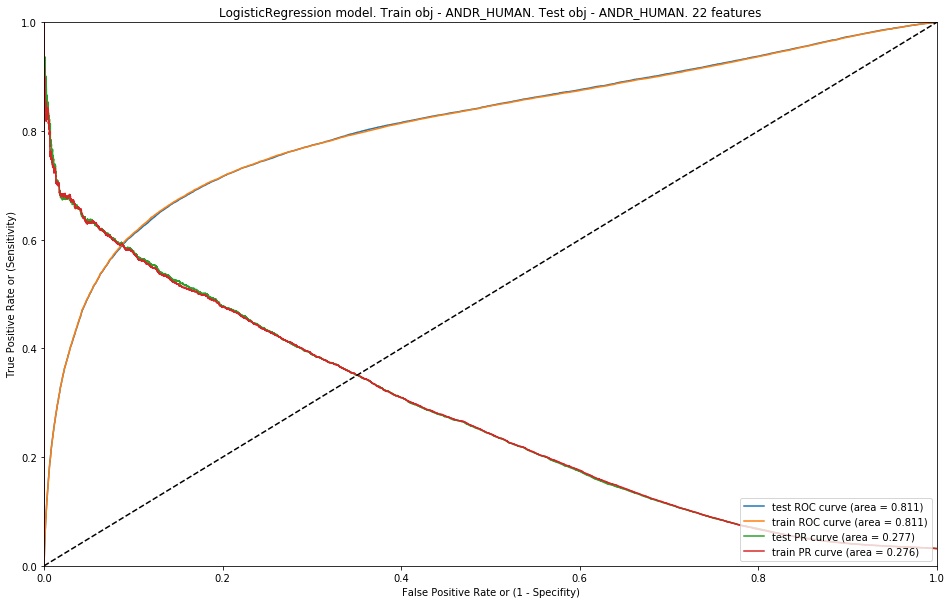

In [159]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

fpr_t, tpr_t, thresholds_t = roc_curve(Y_test, Y_test_predicted_proba)
roc_auc_t = auc(fpr_t, tpr_t)
plt.plot(fpr_t, tpr_t, label='test ROC curve (area = %0.3f)' % roc_auc_t)

fpr, tpr, thresholds = roc_curve(Y_train, Y_train_predicted_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='train ROC curve (area = %0.3f)' % roc_auc)

precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_predicted_proba)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label='test PR curve (area = %0.3f)' % pr_auc)

precision_t, recall_t, thresholds_t = precision_recall_curve(Y_train, Y_train_predicted_proba)
pr_auc_t = auc(recall_t, precision_t)
plt.plot(recall_t, precision_t, label='train PR curve (area = %0.3f)' % pr_auc_t)

plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0
          , 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('LogisticRegression model. Train obj - ANDR_HUMAN. Test obj - ANDR_HUMAN. № of features is {N}'.format(N=N_features))
plt.legend(loc="lower right")
show()
#plt.savefig('5_features.png', dpi=100)

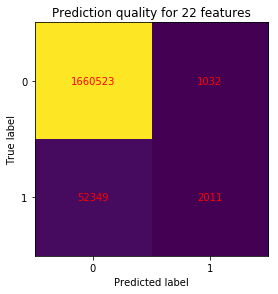

In [161]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

x_ax = ["0", "1"]
y_ax = ["0", "1"]

harvest = np.array(matrix)


fig, ax = plt.subplots()
im = ax.imshow(matrix)

# We want to show all ticks...
ax.set_xticks(np.arange(len(x_ax)))
ax.set_yticks(np.arange(len(y_ax)))
# ... and label them with the respective list entries
ax.set_xticklabels(x_ax)
ax.set_yticklabels(y_ax)

# Loop over data dimensions and create text annotations.
for i in range(len(y_ax)):
    for j in range(len(x_ax)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="r")

ax.set_title('LogisticRegression model. Train obj - ANDR_HUMAN. Test obj - ANDR_HUMAN. № of features is {N}'.format(N=N_features))

fig.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [104]:
logreg = LogisticRegression(random_state = 1)
logreg.fit(X_train, Y_train)
score = np.mean(cross_val_score(logreg,  X_train, Y_train, scoring='accuracy'))
p_scores = np.mean(cross_val_score(logreg,  X_train, Y_train, scoring='precision'))
r_scores = np.mean(cross_val_score(logreg,  X_train, Y_train, scoring='recall'))
print("Accuracy: %s" % '{:.2%}'.format(score))
print ('Precision : %s' %'{:.2%}' .format(p_scores))
print ('Recall score: %s' % '{:.2%}'.format(r_scores))
Y_test_predicted_proba = model.predict_proba(X_test)[:, 1]
Y_train_predicted_proba = model.predict_proba(X_train)[:, 1]
print("roc_auc_score", roc_auc_score(y_score=Y_test_predicted_proba, y_true=Y_test))
print("average_precision_score", average_precision_score(y_score=Y_test_predicted_proba, y_true=Y_test))


Accuracy: 96.84%
Precision : 0.00%
Recall score: 0.00%
roc_auc_score 0.715631223791608
average_precision_score 0.13265623979146884


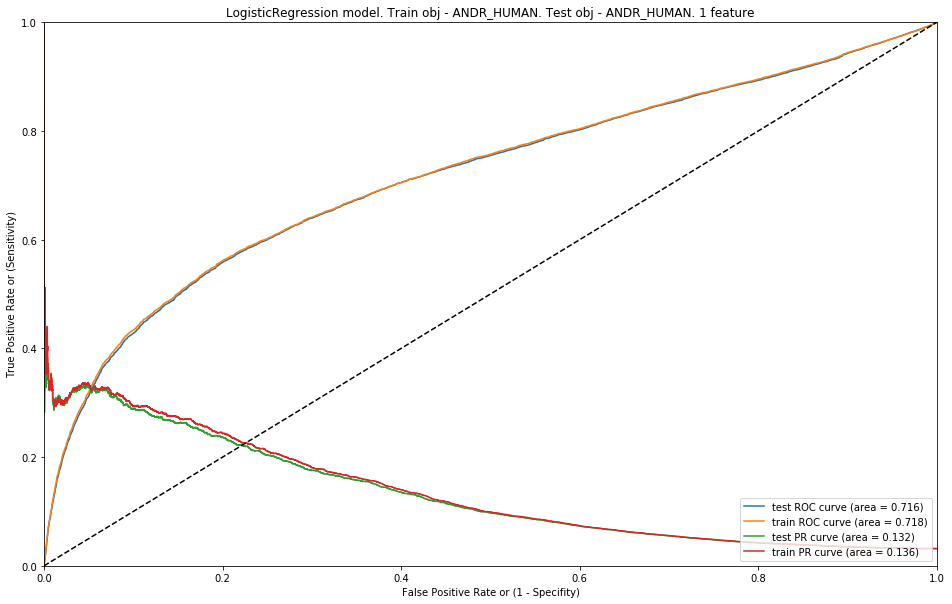

In [105]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

fpr_t, tpr_t, thresholds_t = roc_curve(Y_test, Y_test_predicted_proba)
roc_auc_t = auc(fpr_t, tpr_t)
plt.plot(fpr_t, tpr_t, label='test ROC curve (area = %0.3f)' % roc_auc_t)

fpr, tpr, thresholds = roc_curve(Y_train, Y_train_predicted_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='train ROC curve (area = %0.3f)' % roc_auc)

precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_predicted_proba)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label='test PR curve (area = %0.3f)' % pr_auc)

precision_t, recall_t, thresholds_t = precision_recall_curve(Y_train, Y_train_predicted_proba)
pr_auc_t = auc(recall_t, precision_t)
plt.plot(recall_t, precision_t, label='train PR curve (area = %0.3f)' % pr_auc_t)

plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0
          , 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('LogisticRegression model. Number of trees - {n_estimators}. Train obj - ANDR_HUMAN. Test obj - ANDR_HUMAN. № of features is {N}'.format(n_estimators=n_estimators, N=N_features))
plt.legend(loc="lower right")
show()
#plt.savefig('5_features.png', dpi=100)

In [192]:
n_estimators = 10

In [164]:
n_estimators = 10
GB = GradientBoostingClassifier(random_state=1, n_estimators=n_estimators)
GB.fit(X_train, Y_train)
y_pred = GB.predict(X_test)
ascore=accuracy_score(Y_test,y_pred)
pscore=precision_score(Y_test,y_pred)
rscore=recall_score(Y_test,y_pred)
matrix=confusion_matrix(Y_test,y_pred)
print("Accuracy: %s" % '{:.2%}'.format(ascore))
print ('Precision : %s' %'{:.2%}' .format(pscore))
print ('Recall score: %s' % '{:.2%}'.format(rscore))
Y_test_predicted_proba = GB.predict_proba(X_test)[:, 1]
Y_train_predicted_proba = GB.predict_proba(X_train)[:, 1]
print("roc_auc_score", roc_auc_score(y_score=Y_test_predicted_proba, y_true=Y_test))
print("average_precision_score", average_precision_score(y_score=Y_test_predicted_proba, y_true=Y_test))


Accuracy: 96.94%
Precision : 68.50%
Recall score: 6.13%
roc_auc_score 0.8187226654225773
average_precision_score 0.28895763291221105


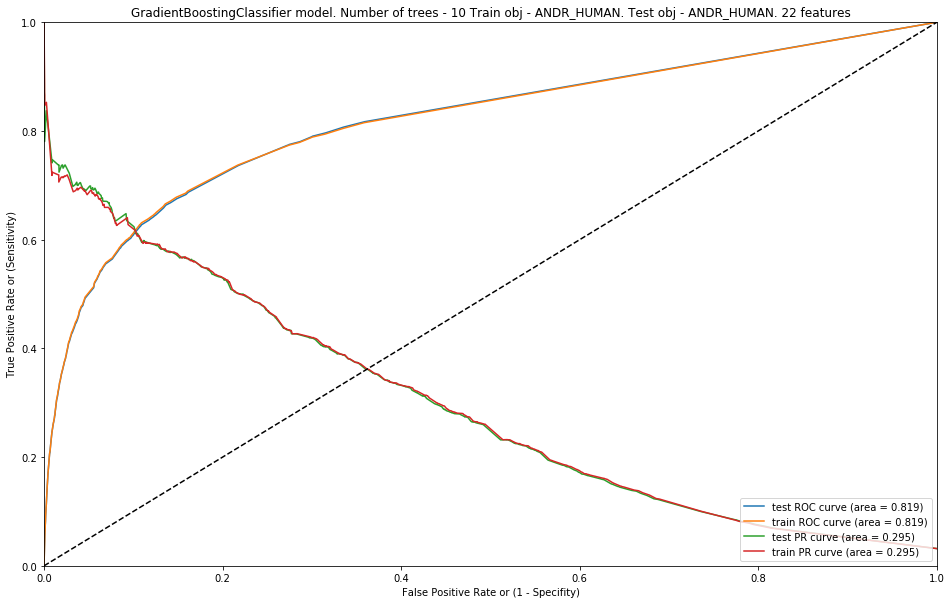

In [165]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

fpr_t, tpr_t, thresholds_t = roc_curve(Y_test, Y_test_predicted_proba)
roc_auc_t = auc(fpr_t, tpr_t)
plt.plot(fpr_t, tpr_t, label='test ROC curve (area = %0.3f)' % roc_auc_t)

fpr, tpr, thresholds = roc_curve(Y_train, Y_train_predicted_proba)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='train ROC curve (area = %0.3f)' % roc_auc)

precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_predicted_proba)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label='test PR curve (area = %0.3f)' % pr_auc)

precision_t, recall_t, thresholds_t = precision_recall_curve(Y_train, Y_train_predicted_proba)
pr_auc_t = auc(recall_t, precision_t)
plt.plot(recall_t, precision_t, label='train PR curve (area = %0.3f)' % pr_auc_t)

plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0
          , 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('GradientBoostingClassifier model. Number of trees - {n_estimators}. Train obj - ANDR_HUMAN. Test obj - ANDR_HUMAN. № of features is {N}'.format(n_estimators=n_estimators, N=N_features))
plt.legend(loc="lower right")
show()
#plt.savefig('5_features.png', dpi=100)

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

x_ax = ["0", "1"]
y_ax = ["0", "1"]

harvest = np.array(matrix)


fig, ax = plt.subplots()
im = ax.imshow(matrix)

# We want to show all ticks...
ax.set_xticks(np.arange(len(x_ax)))
ax.set_yticks(np.arange(len(y_ax)))
# ... and label them with the respective list entries
ax.set_xticklabels(x_ax)
ax.set_yticklabels(y_ax)

# Loop over data dimensions and create text annotations.
for i in range(len(y_ax)):
    for j in range(len(x_ax)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="r")

ax.set_title('GradientBoostingClassifier model. Number of trees - {n_estimators}. Train obj - ANDR_HUMAN. Test obj - ANDR_HUMAN. № of features is {N}'.format(n_estimators=n_estimators, N=N_features))
fig.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [118]:
from sklearn.model_selection import KFold, cross_val_score
cross_val_score(X=X_train, y=Y_train,
                estimator=GradientBoostingClassifier(random_state=1, n_estimators=1), 
                cv=KFold(n_splits=5),
                scoring="roc_auc",
               verbose=3)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  ................................................................
[CV] ....................... , score=0.7068990777480861, total=   7.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV] ....................... , score=0.7050751630160337, total=   6.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.0s remaining:    0.0s


[CV] ....................... , score=0.7052442057558399, total=   6.8s
[CV]  ................................................................
[CV] ....................... , score=0.7062783339303945, total=   6.7s
[CV]  ................................................................
[CV] ........................ , score=0.709897115479797, total=   6.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.5s finished


array([0.70689908, 0.70507516, 0.70524421, 0.70627833, 0.70989712])

In [ ]:
На мыши

In [184]:
score = np.mean(cross_val_score(logreg,  X_train, Y_train, scoring='accuracy'))
p_scores = np.mean(cross_val_score(logreg,  X_train, Y_train, scoring='precision'))
r_scores = np.mean(cross_val_score(logreg,  X_train, Y_train, scoring='recall'))
print("Accuracy: %s" % '{:.2%}'.format(score))
print ('Precision : %s' %'{:.2%}' .format(p_scores))
print ('Recall score: %s' % '{:.2%}'.format(r_scores))
Y_test_predicted_proba = model.predict_proba(X_test)[:, 1]
Y_train_predicted_proba = model.predict_proba(X_train)[:, 1]
print("roc_auc_score", roc_auc_score(y_score=Y_test_predicted_proba, y_true=Y_test))
print("average_precision_score", average_precision_score(y_score=Y_test_predicted_proba, y_true=Y_test))


Accuracy: 99.61%
Precision : 0.00%
Recall score: 0.00%
roc_auc_score 0.8324298829783405
average_precision_score 0.0652673915681968


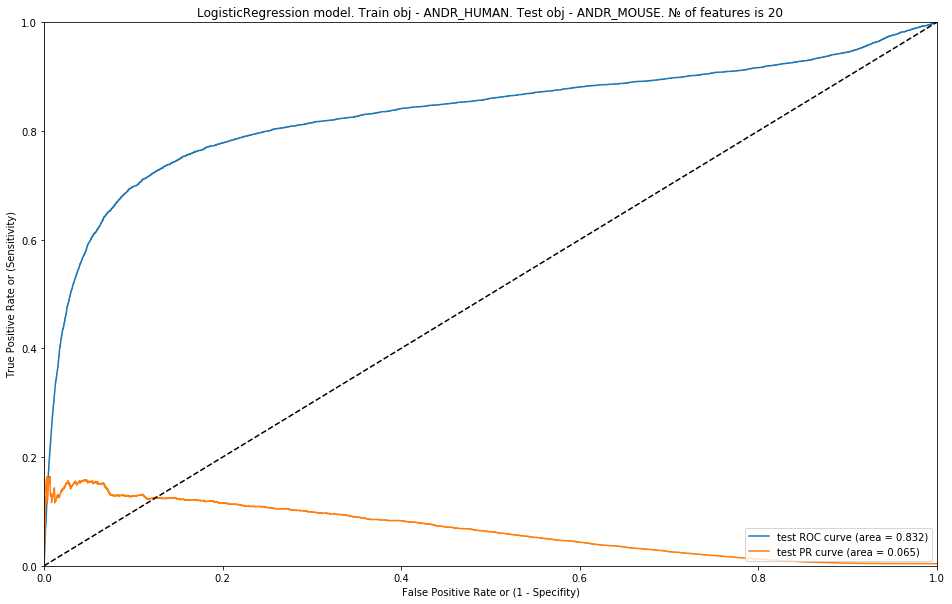

In [193]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

fpr_t, tpr_t, thresholds_t = roc_curve(Y_test, Y_test_predicted_proba)
roc_auc_t = auc(fpr_t, tpr_t)
plt.plot(fpr_t, tpr_t, label='test ROC curve (area = %0.3f)' % roc_auc_t)


precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_predicted_proba)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label='test PR curve (area = %0.3f)' % pr_auc)


plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0
          , 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('LogisticRegression model. Train obj - ANDR_HUMAN. Test obj - ANDR_MOUSE. № of features is {N}'.format(N=N_features))
plt.legend(loc="lower right")
show()
#plt.savefig('5_features.png', dpi=100)

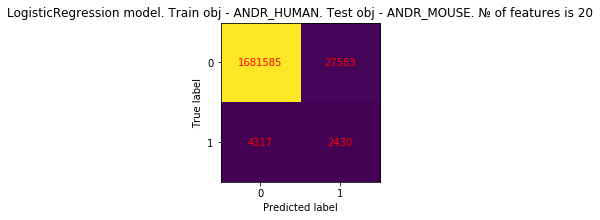

In [194]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

x_ax = ["0", "1"]
y_ax = ["0", "1"]

harvest = np.array(matrix)


fig, ax = plt.subplots()
im = ax.imshow(matrix)

# We want to show all ticks...
ax.set_xticks(np.arange(len(x_ax)))
ax.set_yticks(np.arange(len(y_ax)))
# ... and label them with the respective list entries
ax.set_xticklabels(x_ax)
ax.set_yticklabels(y_ax)

# Loop over data dimensions and create text annotations.
for i in range(len(y_ax)):
    for j in range(len(x_ax)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="r")

plt.title('LogisticRegression model. Train obj - ANDR_HUMAN. Test obj - ANDR_MOUSE. № of features is {N}'.format(N=N_features))
fig.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

In [181]:
y_pred = GB.predict(X_test)
ascore=accuracy_score(Y_test,y_pred)
pscore=precision_score(Y_test,y_pred)
rscore=recall_score(Y_test,y_pred)
matrix=confusion_matrix(Y_test,y_pred)
print("Accuracy: %s" % '{:.2%}'.format(ascore))
print ('Precision : %s' %'{:.2%}' .format(pscore))
print ('Recall score: %s' % '{:.2%}'.format(rscore))
Y_test_predicted_proba = GB.predict_proba(X_test)[:, 1]
Y_train_predicted_proba = GB.predict_proba(X_train)[:, 1]
print("roc_auc_score", roc_auc_score(y_score=Y_test_predicted_proba, y_true=Y_test))
print("average_precision_score", average_precision_score(y_score=Y_test_predicted_proba, y_true=Y_test))


Accuracy: 98.14%
Precision : 8.10%
Recall score: 36.02%
roc_auc_score 0.841965825879853
average_precision_score 0.055092812402534184


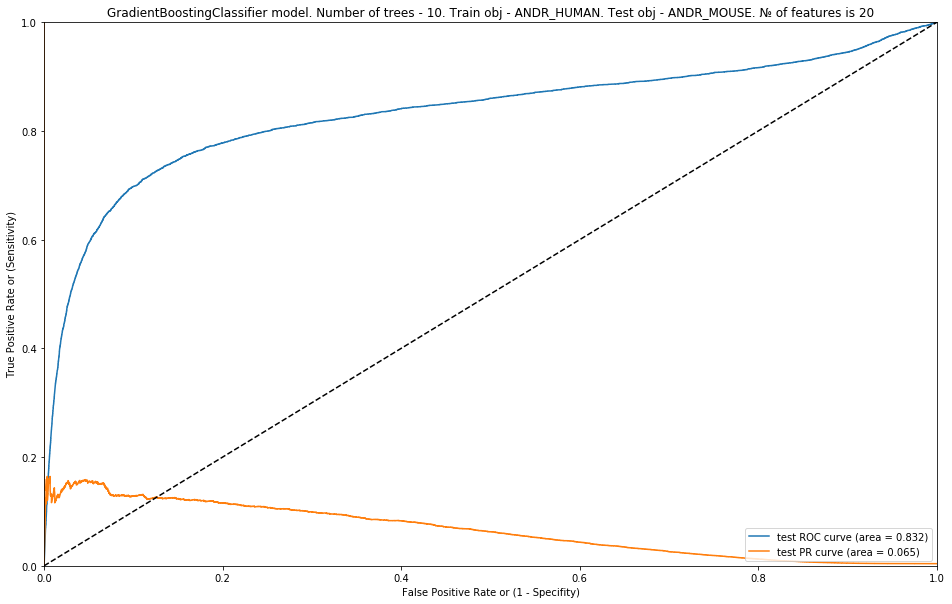

<Figure size 432x288 with 0 Axes>

In [195]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(16, 10)

fpr_t, tpr_t, thresholds_t = roc_curve(Y_test, Y_test_predicted_proba)
roc_auc_t = auc(fpr_t, tpr_t)
plt.plot(fpr_t, tpr_t, label='test ROC curve (area = %0.3f)' % roc_auc_t)

precision, recall, thresholds = precision_recall_curve(Y_test, Y_test_predicted_proba)
pr_auc = auc(recall, precision)
plt.plot(recall, precision, label='test PR curve (area = %0.3f)' % pr_auc)

plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0
          , 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('GradientBoostingClassifier model. Number of trees - {n_estimators}. Train obj - ANDR_HUMAN. Test obj - ANDR_MOUSE. № of features is {N}'.format(n_estimators=n_estimators, N=N_features))
plt.legend(loc="lower right")
show()
plt.savefig('5_features.png', dpi=100)

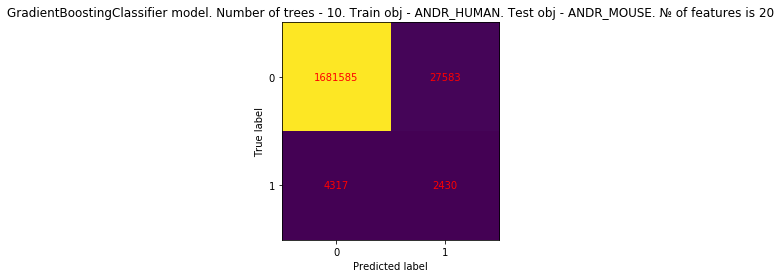

In [196]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

x_ax = ["0", "1"]
y_ax = ["0", "1"]

harvest = np.array(matrix)


fig, ax = plt.subplots()
im = ax.imshow(matrix)

# We want to show all ticks...
ax.set_xticks(np.arange(len(x_ax)))
ax.set_yticks(np.arange(len(y_ax)))
# ... and label them with the respective list entries
ax.set_xticklabels(x_ax)
ax.set_yticklabels(y_ax)

# Loop over data dimensions and create text annotations.
for i in range(len(y_ax)):
    for j in range(len(x_ax)):
        text = ax.text(j, i, harvest[i, j],
                       ha="center", va="center", color="r")

ax.set_title('GradientBoostingClassifier model. Number of trees - {n_estimators}. Train obj - ANDR_HUMAN. Test obj - ANDR_MOUSE. № of features is {N}'.format(n_estimators=n_estimators, N=N_features))
fig.tight_layout()
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()